STEP 1 — Load Data & Inspect Structure

✔ Why?

To understand what variables exist, data types, missing values, and data quality issues.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


demo = pd.read_excel("/kaggle/input/customer-churn-data/Customer_Churn_Data_Large.xlsx", sheet_name="Customer_Demographics")
trans = pd.read_excel("/kaggle/input/customer-churn-data/Customer_Churn_Data_Large.xlsx", sheet_name="Transaction_History")
service = pd.read_excel("/kaggle/input/customer-churn-data/Customer_Churn_Data_Large.xlsx", sheet_name="Customer_Service")
online = pd.read_excel("/kaggle/input/customer-churn-data/Customer_Churn_Data_Large.xlsx", sheet_name= "Online_Activity")
churn = pd.read_excel("/kaggle/input/customer-churn-data/Customer_Churn_Data_Large.xlsx", sheet_name="Churn_Status")


#Quick Inspection for each dataset

datasets={
    "Demographics": demo,
    "Transactions": trans,
    "Customer Service": service,
    "Online Activity": online,
    "Churn": churn
    
}

for name, df in datasets.items():
   print (f"\n===== {name} =====")
   print (df.info())
   print (df.head())



===== Demographics =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     1000 non-null   int64 
 1   Age            1000 non-null   int64 
 2   Gender         1000 non-null   object
 3   MaritalStatus  1000 non-null   object
 4   IncomeLevel    1000 non-null   object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB
None
   CustomerID  Age Gender MaritalStatus IncomeLevel
0           1   62      M        Single         Low
1           2   65      M       Married         Low
2           3   18      M        Single         Low
3           4   21      M       Widowed         Low
4           5   21      M      Divorced      Medium

===== Transactions =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5054 entries, 0 to 5053
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------    

In [2]:
demo.info()
demo.isnull().sum()

trans.describe()
service.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     1000 non-null   int64 
 1   Age            1000 non-null   int64 
 2   Gender         1000 non-null   object
 3   MaritalStatus  1000 non-null   object
 4   IncomeLevel    1000 non-null   object
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


0

STEP 2 — Feature Engineering (Required for EDA)

Many important churn drivers are not directly available — you must compute them.

✔ Why?

Customers don’t churn because of a single transaction.
They churn because of patterns like:

low login frequency

high unresolved complaints

declining purchase behaviour

long time since last interaction

Transaction Aggregate

In [3]:
trans['TransactionDate'] = pd.to_datetime(trans['TransactionDate'])

trans_agg = trans.groupby("CustomerID").agg(
    TransactionCount=("TransactionID", "count"),
    TotalSpend=("AmountSpent", "sum"),
    AvgSpend=("AmountSpent", "mean"),
    LastPurchase=("TransactionDate", "max")
).reset_index()

ref_date = trans["TransactionDate"].max()
trans_agg["DaysSinceLastPurchase"] = (ref_date - trans_agg["LastPurchase"]).dt.days

Service Aggregates

In [4]:
service['InteractionDate'] = pd.to_datetime(service['InteractionDate'])

service_agg = service.groupby("CustomerID").agg(
    InteractionCount=("InteractionID", "count"),
    UnresolvedCount=("ResolutionStatus", lambda x: (x == "Unresolved").sum()),
    LastInteraction=("InteractionDate", "max")
).reset_index()

ref_service = service["InteractionDate"].max()
service_agg["DaysSinceLastInteraction"] = (ref_service - service_agg["LastInteraction"]).dt.days

Online Activity Aggregates

In [5]:
online['LastLoginDate'] = pd.to_datetime(online['LastLoginDate'])

ref_login = online["LastLoginDate"].max()
online["DaysSinceLastLogin"] = (ref_login - online["LastLoginDate"]).dt.days

STEP 3 — Combine Everything (Master Dataset for EDA)

✔ Why?

To compare churners vs non-churners across all metrics.

In [6]:
cust = demo.merge(trans_agg, on="CustomerID", how="left")
cust = cust.merge(service_agg, on="CustomerID", how="left")
cust = cust.merge(online, on="CustomerID", how="left")
cust = cust.merge(churn, on="CustomerID", how="left")

# Fill missing (means no activity)
cust = cust.fillna({
    "TransactionCount": 0,
    "TotalSpend": 0,
    "AvgSpend": 0,
    "DaysSinceLastPurchase": cust["DaysSinceLastPurchase"].max(),
    "InteractionCount": 0,
    "UnresolvedCount": 0,
    "DaysSinceLastInteraction": cust["DaysSinceLastInteraction"].max(),
    "LoginFrequency": 0,
    "DaysSinceLastLogin": cust["DaysSinceLastLogin"].max()
})

STEP 4 — Statistical Techniques for Churn Analysis

4A — Summary Statistics

✔ Why?

To see whether churners differ in spending, interactions, or engagement.

In [7]:
cust.groupby("ChurnStatus")[[
    "Age","TransactionCount","TotalSpend","InteractionCount",
    "UnresolvedCount", "LoginFrequency", "DaysSinceLastLogin"
]].mean()

,Age,TransactionCount,TotalSpend,InteractionCount,UnresolvedCount,LoginFrequency,DaysSinceLastLogin
ChurnStatus,,,,,,,
0,43.040201,5.065327,1266.580038,1.000000,0.477387,26.492462,177.624372
1,44.151961,5.009804,1269.006078,1.009804,0.485294,23.647059,179.980392


STEP 5 — Visual Exploratory Data Analysis (Core Requirement)

Below are the exact visuals needed:
✔ Histograms
✔ Box Plots
✔ Scatter Plots
✔ Correlation Heatmaps

5A — Histograms (Distribution Insights)

Used to understand distributions and compare churners vs non-churners.

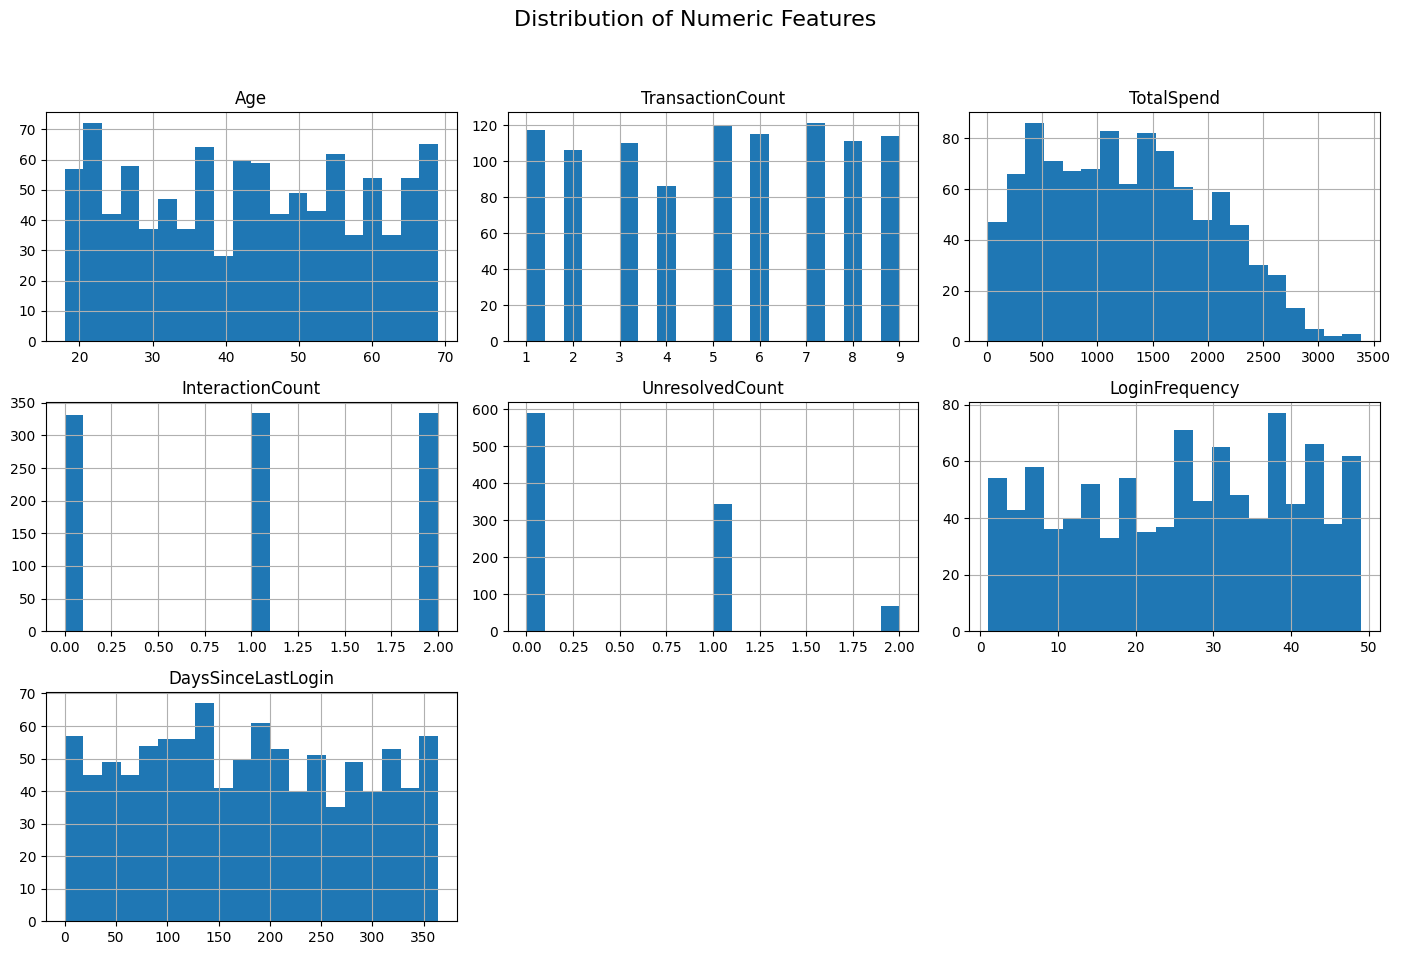

In [8]:
numeric_cols = [
    "Age", "TransactionCount", "TotalSpend",
    "InteractionCount", "UnresolvedCount",
    "LoginFrequency", "DaysSinceLastLogin"
]

# Create the figure explicitly
fig, axes = plt.subplots(
    nrows=3, ncols=3, figsize=(14, 10)
)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot histograms manually (avoids blank save issue)
for ax, col in zip(axes, numeric_cols):
    cust[col].hist(bins=20, ax=ax)
    ax.set_title(col)

# Remove unused subplots
for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

# Add a main title
fig.suptitle("Distribution of Numeric Features", fontsize=16)

# Adjust layout BEFORE saving
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save BEFORE showing
fig.savefig(
    "/kaggle/working/numeric_feature_distributions.png",
    dpi=300,
    bbox_inches="tight"
)

# Display and close
plt.show()
plt.close(fig)



5B — Box Plots (Outliers + Churn Differences)

Shows how churners differ from non-churners.

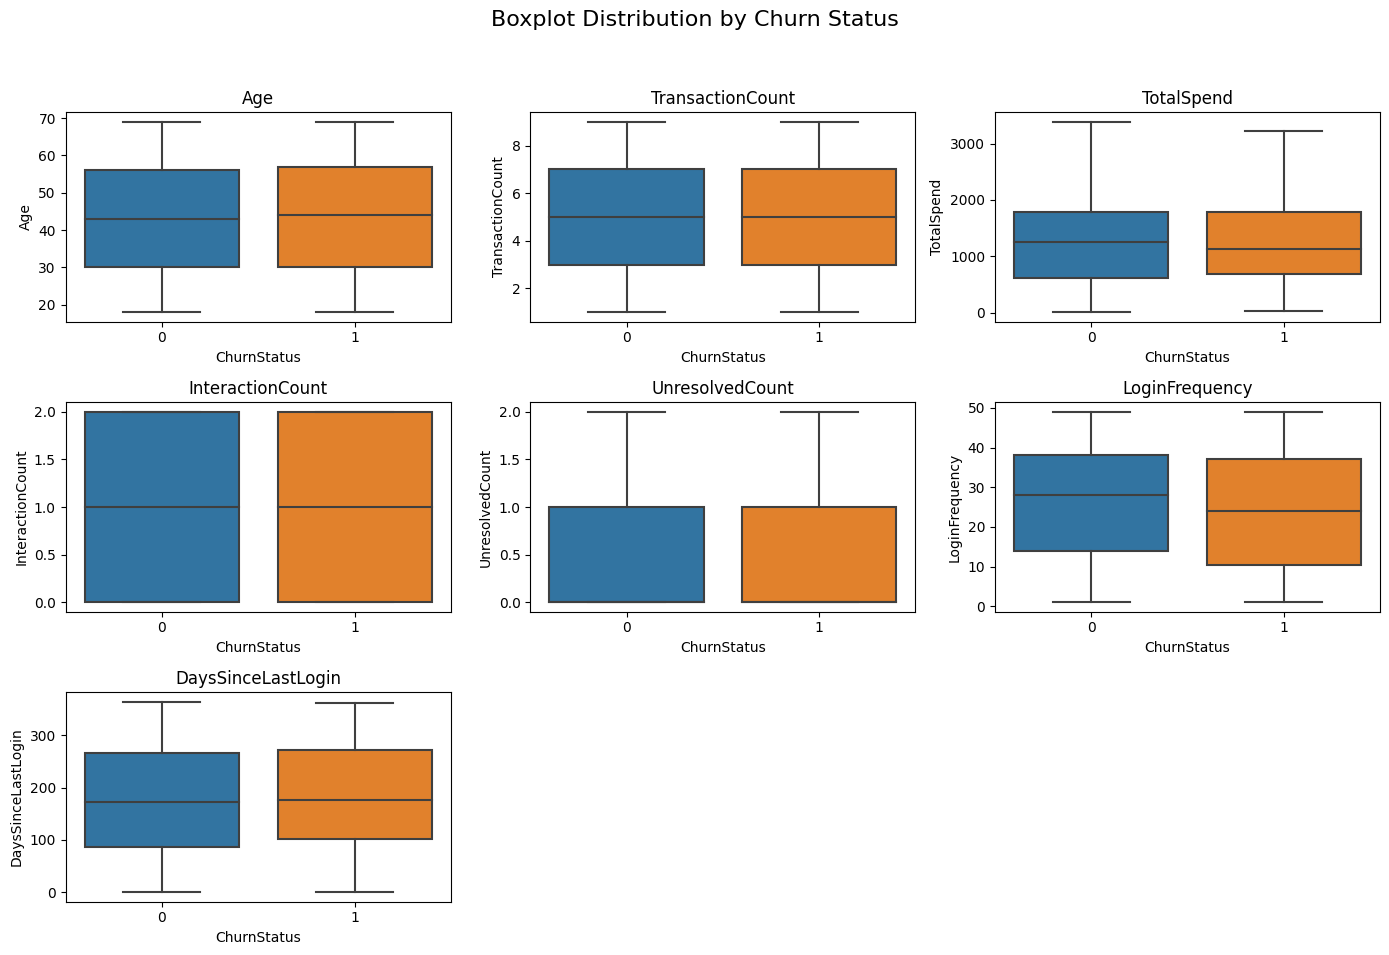

In [9]:
fig, axes = plt.subplots(
    nrows=3, ncols=3, figsize=(14,10)
)

axes = axes.flatten()

for ax, col in zip(axes, numeric_cols):
    sns.boxplot(data=cust, x="ChurnStatus", y=col, ax=ax)
    ax.set_title(col)

for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle("Boxplot Distribution by Churn Status", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.savefig(
    "/kaggle/working/boxplot_distribution.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()
plt.close(fig)


5C — Scatter Plots (Relationships Between Variables)

✔ Example: Engagement vs Spending

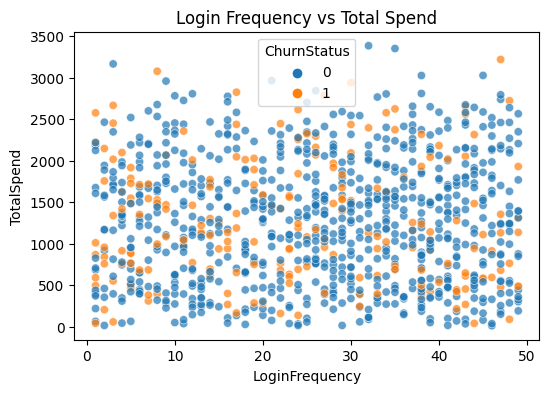

In [10]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=cust,
    x="LoginFrequency",
    y="TotalSpend",
    hue="ChurnStatus",
    alpha=0.7,
)
plt.title("Login Frequency vs Total Spend")

# Save BEFORE show
plt.savefig("loginFrequency_vs_totalSpend_scatterplot_distribution.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()


✔ Example: Recency vs Complaints


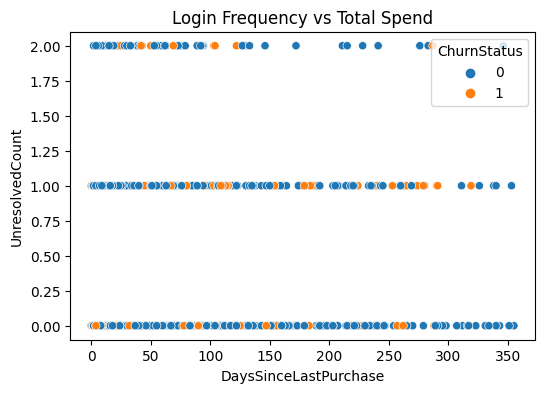

In [11]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=cust, x="DaysSinceLastPurchase", y="UnresolvedCount", hue="ChurnStatus")
plt.title("Recency of Purchase vs Complaint Count")

plt.title("Login Frequency vs Total Spend")

# Save BEFORE show
plt.savefig("scatterplot_distribution.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()

5D — Correlation Heatmap (Feature Importance Pre-Check)

A powerful statistical technique.

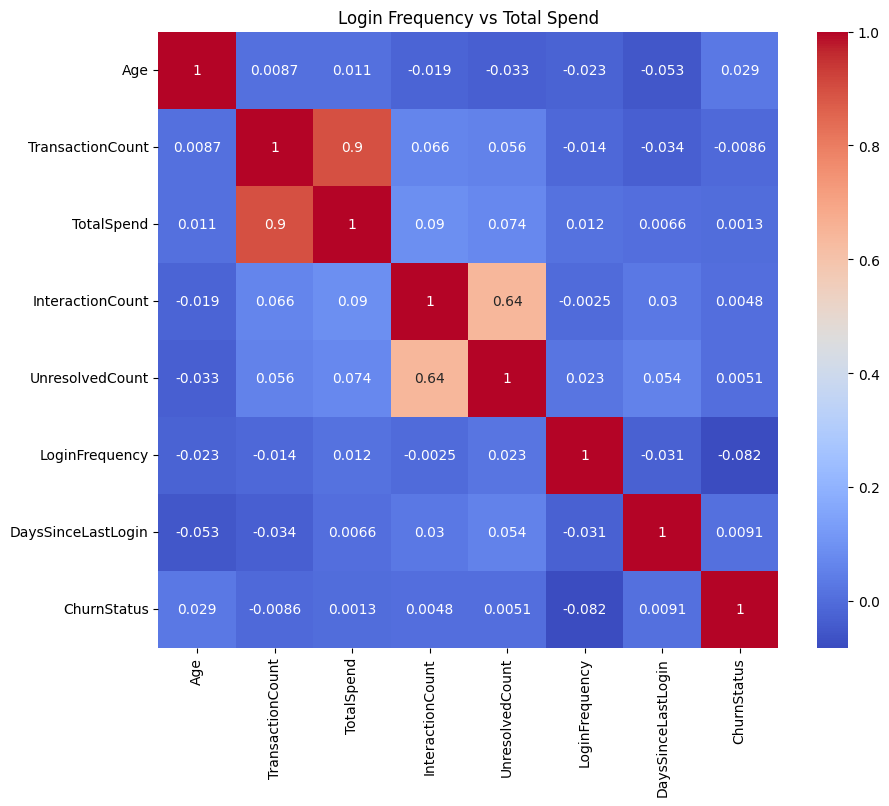

In [12]:
plt.figure(figsize=(10,8))
sns.heatmap(cust[numeric_cols + ["ChurnStatus"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.title("Login Frequency vs Total Spend")

# Save BEFORE show
plt.savefig("correlation.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close()


✔ What This Reveals:

Features strongly correlated with ChurnStatus

Red flags such as multicollinearity

Key features for modeling


STEP 6 — Identify Key Churn Drivers (Statistical Evidence)

In [13]:
numeric_df = cust.select_dtypes(include=["int64", "float64"])

corrs = numeric_df.corr()["ChurnStatus"].sort_values(ascending=False)
print(corrs)

ChurnStatus                 1.000000
AvgSpend                    0.044811
DaysSinceLastInteraction    0.035587
Age                         0.029407
DaysSinceLastLogin          0.009055
UnresolvedCount             0.005132
InteractionCount            0.004841
DaysSinceLastPurchase       0.003362
TotalSpend                  0.001324
TransactionCount           -0.008598
CustomerID                 -0.011528
LoginFrequency             -0.081615
Name: ChurnStatus, dtype: float64


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


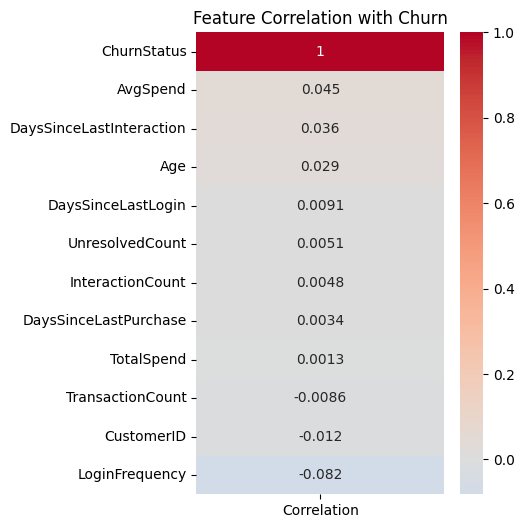

In [14]:
corrs_df = corrs.to_frame(name="Correlation")

fig, ax = plt.subplots(figsize=(4,6))

sns.heatmap(
    corrs_df,
    annot=True,
    cmap="coolwarm",
    center=0,
    ax=ax
)

ax.set_title("Feature Correlation with Churn")

fig.savefig(
    "/kaggle/working/churn_correlation_heatmap.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()
plt.close(fig)


Exporting Cleaned Dataset 

In [15]:
cust.to_excel(
    "/kaggle/working/cleaned_customer_churn_data.xlsx",
    index=False
)

In [16]:
cust.head()
cust.shape
cust.isnull().sum()

CustomerID                    0
Age                           0
Gender                        0
MaritalStatus                 0
IncomeLevel                   0
TransactionCount              0
TotalSpend                    0
AvgSpend                      0
LastPurchase                  0
DaysSinceLastPurchase         0
InteractionCount              0
UnresolvedCount               0
LastInteraction             332
DaysSinceLastInteraction      0
LastLoginDate                 0
LoginFrequency                0
ServiceUsage                  0
DaysSinceLastLogin            0
ChurnStatus                   0
dtype: int64